In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from functools import reduce
import numpy as np
from datetime import datetime
import os
import pandas as pd
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# Download and unpack the data

The project focuses on analyzing train delays using data collected from the website http://ipa.lovethosetrains.com/. This site, known as InfoPasażer Archives, serves as an archive of information sourced from the InfoPasażer service maintained by PKP. InfoPasażer provides detailed information about trains in Poland, including their current locations and delays.

After obtaining the data, it was processed and saved in a structured format containing information about:

- **Train Name:** Unique identifiers for each train.
- **Date:** Dates related to the last stations of each train.
- **Delays:** Information about delays at the last station.

Update: the site was discontinued, data can be found on some one/google drives. As it weights ~16GB it cannot be uploaded to GitHub.

Filter for trains running throughout the years, some trains run only for 1 year due to constructions, so they are concidered to be outliers.

In [2]:
def trains_running_throughout_the_years(
    data_folder_path="/Data/",
):
    folders_files = []  # list with lists of filenames in each train* folder
    for folders_index, train_folder in enumerate(
        os.listdir(os.getcwd() + data_folder_path)
    ):
        folders_files.append([])  # new list with file names
        for filename in os.listdir(os.getcwd() + data_folder_path + train_folder):
            folders_files[folders_index].append(filename)

    return list(reduce(set.intersection, [set(item) for item in folders_files]))

In [3]:
def filter_and_export_data_delays(data_folder_path="Data", save_filename="traindelays"):
    # We will save the trains name and its delay on date
    train_names = []
    dates = []
    delays = []

    trains_filter = trains_running_throughout_the_years()
    path_to_data_folder = os.path.join(os.getcwd(), data_folder_path)

    for train_folder in os.listdir(path_to_data_folder):
        path_to_train_folder = os.path.join(data_folder_path, train_folder)
        for filename in os.listdir(path_to_train_folder):

            if filename not in trains_filter:
                continue

            with open(
                os.path.join(path_to_train_folder, filename), "r"
            ) as f:  # open in readonly mode

                data = json.load(f)
                schedules = data["schedules"]
                train_ids = data["train_id"]
                train_name = data["train_name"]

                for schedule in schedules:
                    parsed = json.dumps(schedule)
                    parsed_json = json.loads(parsed)
                    parsed_json_info = parsed_json["info"]

                    if not parsed_json_info:  # skip empty arrays so [-1] doesnt crash
                        continue

                    last_station = parsed_json_info[-1]
                    dates.append(pd.to_datetime(last_station["arrival_time"][:10]))
                    delays.append(last_station["arrival_delay"])
                    train_names.append(train_name)

                f.close()
    # save to binary file
    np.save(save_filename, [dates, train_names, delays])

In [4]:
def filter_and_export_data_stations(
    data_folder_path="Data", save_filename="trainstations.npy"
):
    # We will save the trains name and its delay on date
    train_names = []
    stations = []
    years = []

    trains_filter = trains_running_throughout_the_years()
    path_to_data_folder = os.path.join(os.getcwd(), data_folder_path)

    for train_folder in os.listdir(path_to_data_folder):
        path_to_train_folder = os.path.join(data_folder_path, train_folder)

        for filename in os.listdir(path_to_train_folder):

            if filename not in trains_filter:
                continue

            with open(
                os.path.join(path_to_train_folder, filename), "r"
            ) as f:  # open in readonly mode

                data = json.load(f)
                schedules = data["schedules"]
                train_ids = data["train_id"]
                train_name = data["train_name"]

                # =========================
                # We only need one schedule, stations dont change often
                schedule = schedules[0]
                parsed = json.dumps(schedule)
                parsed_json = json.loads(parsed)
                parsed_json_info = parsed_json["info"]

                if not parsed_json_info:  # skip empty arrays so [-1] doesnt crush
                    continue

                single_train_station_names = [
                    info["station_name"] for info in parsed_json_info
                ]
                year = parsed_json_info[-1]["arrival_time"][:4]
                for station_name in single_train_station_names:
                    train_names.append(train_name)
                    stations.append(station_name)
                    years.append(year)

                f.close()

    np.save(save_filename, [years, train_names, stations])

In [5]:
# For using google colab
# from google.colab import drive
# drive.mount('/content/drive/')
# [dates, train_names, delays] = np.load('/content/drive/MyDrive/Data/traindelays.npy', allow_pickle=True)

**Unpack data**

In [6]:
[dates, train_names, delays] = np.load("traindelays.npy", allow_pickle=True)

In [7]:
df_delays = pd.DataFrame({"Date": dates, "Train_name": train_names, "Delay": delays})
df_delays.head()

,Date,Train_name,Delay
0,2017-12-09,11364/5,0
1,2017-12-08,11364/5,0
2,2017-12-07,11364/5,0
3,2017-12-06,11364/5,0
4,2017-12-05,11364/5,0


Before cleaning up data lets take have a general idea of how it pans out

First lets take a look at the delays distribution
# Outliers

In the case of train delays, outliers can represent situations that significantly deviate from the typical patterns of delays. As a result of removing outliers, the data becomes more balanced, allowing for a more reliable statistical analysis and a better understanding of the characteristics of delays in the railway system.


A delay histogram was created, allowing us to see in which time ranges delays most frequently occur.

/home/michalba/Projects/ML/TrainDelays/myenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7129: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


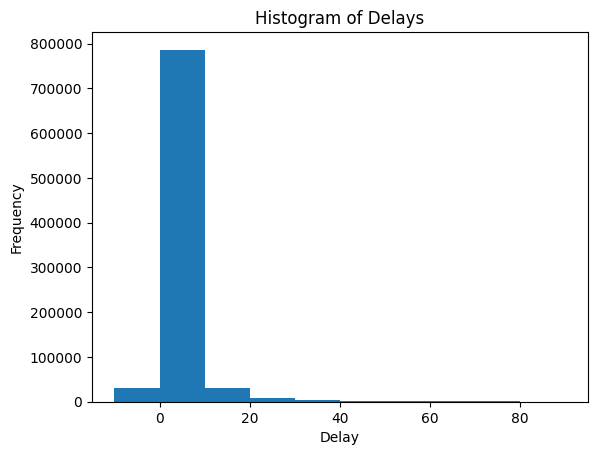

In [8]:
bins = [x for x in range(-10, 100, 10)] + [float("inf")]
plt.hist(df_delays["Delay"], bins=bins)
plt.xlabel("Delay")
plt.ylabel("Frequency")
plt.title("Histogram of Delays")
plt.show()

We can see that most of the trains have the delay between [0,10] minutes

Now lets take a look how often trains run

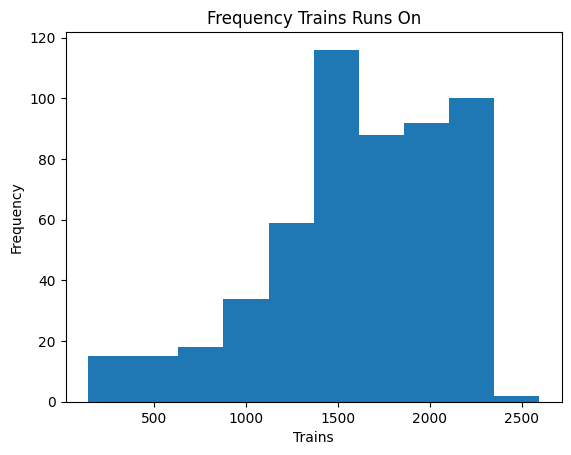

In [9]:
train_days = df_delays["Train_name"].value_counts()
train_days.head()
# train_days.values.hist(grid=False, bins=100, rwidth=0.9)
# train_days.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6))
plt.hist(train_days.values)
plt.xlabel("Trains")
plt.ylabel("Frequency")
plt.title("Frequency Trains Runs On")
plt.show()

Lets find trains with largest autocorrelation (on lag 1)

In [10]:
df_delays.head()

,Date,Train_name,Delay
0,2017-12-09,11364/5,0
1,2017-12-08,11364/5,0
2,2017-12-07,11364/5,0
3,2017-12-06,11364/5,0
4,2017-12-05,11364/5,0


In [11]:
def find_train_names_with_largest_autocorr(top_autocorr_nr, df=df_delays):
    # Group by 'Train_name' and compute autocorrelation for each train
    train_autocorr = (
        df.groupby("Train_name")["Delay"]
        .apply(lambda x: x.autocorr(lag=1))
        .reset_index(name="Autocorr")
    )

    # Sort by autocorrelation in descending order and get the top train names
    top_train_names = train_autocorr.nlargest(top_autocorr_nr, "Autocorr")[
        "Train_name"
    ].tolist()

    return top_train_names


top_train_names = find_train_names_with_largest_autocorr(5)
print(top_train_names)

['69230', '10411', '59602', '90410', '39432']


These trains are most autocorrelated, probably because they are all regional trains with relatively short distances. It makes them more predictable.

Now lets find correlation between all of the trains

In [12]:
df_wide = df_delays.pivot_table(
    index="Date",  # Use the date as the index
    columns="Train_name",  # Each train becomes a column
    values="Delay",  # Values are the delays
)
df_wide.head()

Train_name,10400,10404,10406,10411,10413,10417,11301,11303,11305,11307,...,96953/2,96955/4,96957/6,96959/8,96961/0,96963/2,96965/4,96985,96987,96989
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-12,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-13,0.0,NaN,0.0,NaN,NaN,0.0,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-14,0.0,NaN,0.0,NaN,NaN,0.0,0.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-15,5.0,NaN,0.0,NaN,NaN,5.0,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train_corrlations_wide = df_wide.corr()
train_corrlations_wide.index.name = "Train1"
train_corrlations_wide.columns.name = "Train2"
train_corrlations_wide.head()

Train2,10400,10404,10406,10411,10413,10417,11301,11303,11305,11307,...,96953/2,96955/4,96957/6,96959/8,96961/0,96963/2,96965/4,96985,96987,96989
Train1,,,,,,,,,,,,,,,,,,,,,
10400,1.000000,0.038924,0.019416,0.119256,0.085693,0.073949,0.002582,0.001622,-0.006607,0.006592,...,-0.000139,0.018556,0.012435,-0.003325,0.066523,-0.010930,0.011210,0.056410,-0.014799,0.002821
10404,0.038924,1.000000,0.082466,0.043577,0.474710,0.114429,0.040268,-0.000015,0.026637,0.011954,...,-0.006028,-0.017561,0.009672,-0.010775,-0.003956,-0.002328,-0.007644,-0.001425,-0.008924,-0.012997
10406,0.019416,0.082466,1.000000,0.106657,0.084806,0.468897,0.018559,0.012187,0.044577,0.019561,...,-0.011970,-0.015127,-0.002848,-0.009658,0.000285,0.001465,0.060006,-0.016443,-0.017374,0.032453
10411,0.119256,0.043577,0.106657,1.000000,0.185098,-0.002047,0.016906,-0.010734,-0.012423,0.014980,...,0.014814,0.039675,-0.006048,-0.003359,0.092219,-0.019091,-0.012256,0.011030,-0.011168,0.096833
10413,0.085693,0.474710,0.084806,0.185098,1.000000,0.069775,0.044584,0.008791,0.042371,0.010269,...,-0.004417,0.002069,0.001854,-0.008893,0.016723,-0.013695,-0.006551,0.028971,0.015497,0.010617


In [14]:
# Flatten the correlation matrix back into long format, correlation is symmetrical
# and we do not want any repetitions ie (train1, train2)  (train2, train1), delete them
# by setting to nan upper triangle
upper_triangle_indices = np.triu_indices_from(train_corrlations_wide, k=0)
train_corrlations_wide.values[upper_triangle_indices] = np.nan
train_correlations_long = train_corrlations_wide.stack().reset_index()
train_correlations_long.columns = ["Train1", "Train2", "Correlation"]

In [15]:
train_correlations_long.nlargest(10, "Correlation").head()

,Train1,Train2,Correlation
32444,60822,23440/1,1.0
46416,76533/2,23440/1,1.0
80671,95317,60561/0,1.0
82448,95327,22923/2,1.0
95257,95459,95301,1.0


These trains being so highly correlated do not make sense. Also correlation is suspiciously high. Lets check based on how many days was the correlation calculted on.

In [16]:
train_dates = df_delays.groupby('Train_name')['Date'].apply(set).to_dict()
train_pairs = train_correlations_long[['Train1', 'Train2']]
results = []
for train1, train2 in tqdm(train_pairs.values):
    dates_train1 = train_dates.get(train1, set())
    dates_train2 = train_dates.get(train2, set())
    common_days_count = len(dates_train1 & dates_train2)
    results.append(common_days_count)

train_correlations_long['CommonDays'] = results

100%|██████████| 144405/144405 [00:12<00:00, 11414.65it/s]


In [17]:
train_correlations_long.nlargest(10, "Correlation").head()

,Train1,Train2,Correlation,CommonDays
32444,60822,23440/1,1.0,2
46416,76533/2,23440/1,1.0,2
80671,95317,60561/0,1.0,6
82448,95327,22923/2,1.0,4
95257,95459,95301,1.0,14


We can see that the correlation is so high because the days both the trains run on were so few. These are not reliable. Lets take only pairs of trains that the # common days is > 100.

In [18]:
train_correlations_long = train_correlations_long[train_correlations_long['CommonDays'] > 100]
train_correlations_long.nlargest(10, "Correlation").head()

,Train1,Train2,Correlation,CommonDays
75894,91862/3,33712,0.868204,165
39578,69230,69228,0.866794,2110
54090,87380,46327,0.816264,231
78884,95307,95305,0.811722,377
47541,76930,76920,0.807509,1410


These trains run in similiar geographical regions in Poland. And the correlation is believable.

Lets check if number of common stations impacts the correlation

In [19]:
# Load the saved file
data = np.load("trainstations.npy", allow_pickle=True)
years, train_names, stations = data
# Create a DataFrame
df_train_stations = pd.DataFrame(
    {"Year": years, "Train Name": train_names, "Station": stations}
)
# Group by Year and Train Name, and get unique combinations of Train Name and Station
df_train_stations_grouped = df_train_stations.groupby(["Year", "Train Name"])[
    "Station"
].unique()
df_train_stations_grouped.head()

Year  Train Name
2016  20304         [Kielce, Kielce Piaski, Kostomłoty, Tumlin, Za...
2017  10400         [Suwałki, Płociczno k/Suwałk, Szczepki, Blizna...
      10404         [Suwałki, Płociczno k/Suwałk, Szczepki, Blizna...
      10406         [Suwałki, Płociczno k/Suwałk, Szczepki, Blizna...
      10411         [Białystok, Wasilków, Czarny Blok, Wólka Ratow...
Name: Station, dtype: object

## For each pair of trains, find the number of common stations in each year

In [20]:
from itertools import combinations

# Initialize an empty list to store results
results = []

# Group the DataFrame by year for easier processing
for year, group in tqdm(df_train_stations_grouped.groupby(level=0)):
    # Get train names and their corresponding stations for the year
    trains = group.index.get_level_values(1)
    stations = group.values

    # Find all unique train pairs and compute common stations
    for (train1, train2), (stations1, stations2) in zip(
        combinations(trains, 2), combinations(stations, 2)
    ):
        common_stations_count = len(np.intersect1d(stations1, stations2))
        results.append((year, train1, train2, common_stations_count))

# Convert results to a DataFrame
df_train_pair_common_stations = pd.DataFrame(
    results, columns=["Year", "Train1", "Train2", "Common Stations"]
)

df_train_pair_common_stations.head()

100%|██████████| 8/8 [00:16<00:00,  2.08s/it]


,Year,Train1,Train2,Common Stations
0,2017,10400,10404,24
1,2017,10400,10406,24
2,2017,10400,10411,24
3,2017,10400,10413,24
4,2017,10400,10417,24


In [21]:
# From multiple years of the train running ,take the mode of nr of common stations throughout the years
df_train_pair_common_stations_moded = (
    df_train_pair_common_stations.groupby(["Train1", "Train2"])
    .agg({"Common Stations": lambda x: x.mode()[0], "Year": "first"})
    .reset_index()
)
df_train_pair_common_stations_moded.head()

,Train1,Train2,Common Stations,Year
0,10400,10404,24,2017
1,10400,10406,24,2017
2,10400,10411,24,2017
3,10400,10413,24,2017
4,10400,10417,24,2017


Quick sanity check:
- df_train_pair_common_stations_moded should be x amount smaller than df_train_pair_common_stations, where x is the number of years for which we have data

In [22]:
print(len(df_train_pair_common_stations) / len(df_train_pair_common_stations_moded))
print(df_train_pair_common_stations["Year"].nunique())

6.992578849721707
7


Merge train stations data with train correlations

In [23]:
# Merge train stations data with train correlations
# with open("/content/drive/MyDrive/Data/correlation_results.pkl", "rb") as f:
#     correlation_results = pickle.load(f)

df_final = pd.merge(
    train_correlations_long,
    df_train_pair_common_stations_moded,
    how="left",
    on=["Train1", "Train2"],
)

# Take into account train names swapped (correlation is symmetrical)
df_train_pair_common_stations_moded = df_train_pair_common_stations_moded.rename(
    columns={"Train1": "Train2", "Train2": "Train1"}
)

df_final = df_final.merge(
    df_train_pair_common_stations_moded[
        ["Train1", "Train2", "Common Stations", "Year"]
    ],
    on=["Train1", "Train2"],
    how="left",
)
# Combine 'Common Stations' and 'Year' columns, and drop the intermediate ones
df_final["Common Stations"] = df_final["Common Stations_x"].combine_first(
    df_final["Common Stations_y"]
)
df_final["Year"] = df_final["Year_x"].combine_first(df_final["Year_y"])
# Drop the redundant columns
df_final.drop(
    ["Common Stations_x", "Common Stations_y", "Year_x", "Year_y"], axis=1, inplace=True
)
df_final.head()

/tmp/ipykernel_1381/2650900698.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_final["Common Stations"] = df_final["Common Stations_x"].combine_first(


,Train1,Train2,Correlation,CommonDays,Common Stations,Year
0,10404,10400,0.038924,2038,24,2017
1,10406,10400,0.019416,2090,24,2017
2,10406,10404,0.082466,2153,24,2017
3,10411,10400,0.119256,1140,24,2017
4,10411,10404,0.043577,1097,24,2017


Sanity check:
- We expect every pair of trains to have a validcorrelation 

In [24]:
df_final[df_final["Common Stations"].isna()]

,Train1,Train2,Correlation,CommonDays,Common Stations,Year


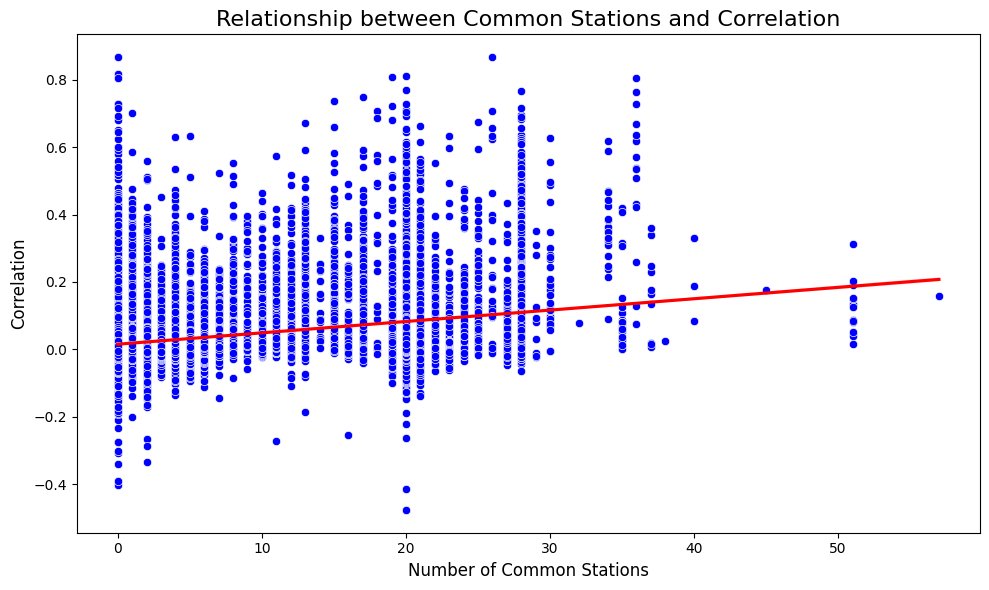

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatter plot using seaborn for better aesthetics
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x="Common Stations", y="Correlation", color="blue")

# Optional: Add a regression line
sns.regplot(
    data=df_final, x="Common Stations", y="Correlation", scatter=False, color="red"
)

# Add labels and title
plt.title("Relationship between Common Stations and Correlation", fontsize=16)
plt.xlabel("Number of Common Stations", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

We can see an upward trend which means that the more common stations trains have the more they are correlated.

To be honest I was hoping for more explicit trend, the data looks still a bit random.

In [26]:
# # If still there are missing values, drop them
# df_final.dropna(subset=["Correlation", "Common Stations"], inplace=True)
# # Filter out trains that have been running for less than 100 days
# df_final = df_final[df_final["Days"] >= 100]

# df_final["Correlation"] = df_final["Correlation"].abs()

In [27]:
# Create bins for the correlation values
bins = [0, 0.1, 0.2, 0.5, 1.0]
labels = ["< 0.1", "0.1 - 0.2", "0.2 - 0.5", "0.5 - 1"]
df_final["corr_bin"] = pd.cut(df_final["Correlation"], bins=bins, labels=labels)
df_final.head()

,Train1,Train2,Correlation,CommonDays,Common Stations,Year,corr_bin
0,10404,10400,0.038924,2038,24,2017,< 0.1
1,10406,10400,0.019416,2090,24,2017,< 0.1
2,10406,10404,0.082466,2153,24,2017,< 0.1
3,10411,10400,0.119256,1140,24,2017,0.1 - 0.2
4,10411,10404,0.043577,1097,24,2017,< 0.1


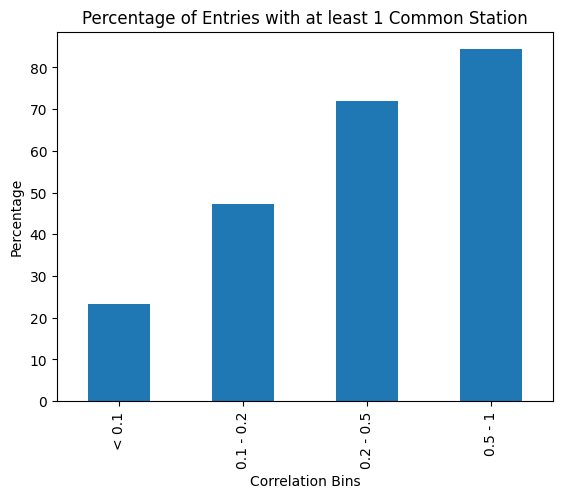

In [28]:
# Calculate the percentage of entries with at least 1 common station in each bin
bin_counts = df_final.groupby("corr_bin", observed=True)["Common Stations"].apply(
    lambda x: (x > 0).sum() / len(x) * 100
)

bin_counts.plot(kind="bar")
plt.xlabel("Correlation Bins")
plt.ylabel("Percentage")
plt.title("Percentage of Entries with at least 1 Common Station")
plt.show()

Lets finally use our overview of the data to find outliers

In [29]:
# Filter out trains that have delays larger than 12 hours or that run on less than 20% of the total days
def find_outliers(df=df_delays):
    train_days = df["Train_name"].value_counts()
    total_days = len(df["Date"].unique())
    threshold = 0.2 * total_days
    outliers = train_days[train_days < threshold].index
    return np.where((abs(df["Delay"]) > 720) | (df["Train_name"].isin(outliers)))

## Use find_outliers to skim our data. Create a pandas dataframe for our data

In [30]:
outliers = find_outliers()
print("Number of outliers removed:", len(outliers[0]))
df_delays = df_delays.drop(outliers[0])
df_delays.head()

Number of outliers removed: 5230


,Date,Train_name,Delay
0,2017-12-09,11364/5,0
1,2017-12-08,11364/5,0
2,2017-12-07,11364/5,0
3,2017-12-06,11364/5,0
4,2017-12-05,11364/5,0


# Data analysis

## Create new dataframes
- df_grouped_monthly_train for each train sums the trains delayed summed in the month. We can say that pair of (Train, Date) columns is the tables key

- df_grouped_monthly_all  sums all sum of all train delays it had in the month. We can say that 'Date' column (which is a month) is the tables key

- df_grouped_daily sums all trains delay on the day. We can say that 'Date' (which is a day) is the tables key

In [31]:
df_grouped_monthly_train = (
    df_delays.groupby([df_delays.Date.dt.to_period("M"), "Train_name"])["Delay"]
    .mean()
    .reset_index()
)
df_grouped_monthly_train = df_grouped_monthly_train.sort_values(by=["Date"])

df_grouped_monthly_all = (
    df_delays.groupby(df_delays.Date.dt.to_period("M"))["Delay"].mean().reset_index()
)
df_grouped_monthly_all = df_grouped_monthly_all.sort_values(by=["Date"])

df_grouped_daily = (
    df_delays.groupby([df_delays.Date.dt.to_period("D")])["Delay"].mean().reset_index()
)
df_grouped_daily = df_grouped_daily.sort_values(by=["Date"])

df_grouped_monthly_train["Date"] = df_grouped_monthly_train["Date"].dt.to_timestamp()
df_grouped_monthly_all["Date"] = df_grouped_monthly_all["Date"].dt.to_timestamp()
df_grouped_daily["Date"] = df_grouped_daily["Date"].dt.to_timestamp()

df_grouped_monthly_train.head()
df_grouped_monthly_all.head()
df_grouped_daily.head()

,Date,Delay
0,2016-12-11,1.560606
1,2016-12-12,2.666667
2,2016-12-13,9.156118
3,2016-12-14,3.781893
4,2016-12-15,2.475


## Plot data with a grid every January, first arg is x axis, second is y axis. In our case (dates, delays)

In [32]:
def plot_data(dates, delays):

    fig, ax = plt.subplots()
    ax.plot(dates, delays)

    # Major ticks every 6 months.
    fmt_half_year = mdates.MonthLocator(bymonth=1)
    ax.xaxis.set_major_locator(fmt_half_year)
    ax.grid(True)
    # Rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them.
    fig.autofmt_xdate()

In [33]:
def autocorr_data(data, maxlag=13, ybottom=-1, ytop=1, step=0, usevlines=True):

    # Plotting the Autocorrelation plot.
    # plt.acorr(data, maxlags = maxlag, usevlines = usevlines)
    plot_acf(data, lags=maxlag, use_vlines=usevlines, zero=False)
    # Adding plot title.
    plt.title("Autocorrelation Plot")

    # Providing x-axis name.
    plt.xlabel("Lags")

    plt.xlim(left=0)

    if ytop != 1:
        plt.ylim(top=ytop)
    if ybottom != -1:
        plt.ylim(bottom=ybottom)

    start = step
    if step > 0:
        for x in range(start, maxlag, step):
            plt.axvline(x=x + 0.5, color="green")

    # plt.show()

## Analyze a single train

In [34]:
all_train_names = list(set(df_delays["Train_name"]))
train_single_name = "10411"
train_single = df_delays[df_delays["Train_name"] == train_single_name]
train_single = train_single.sort_values(by=["Date"])
train_single_monthly = df_grouped_monthly_train[
    df_grouped_monthly_train["Train_name"] == train_single_name
]

- Plot single trains daily delays

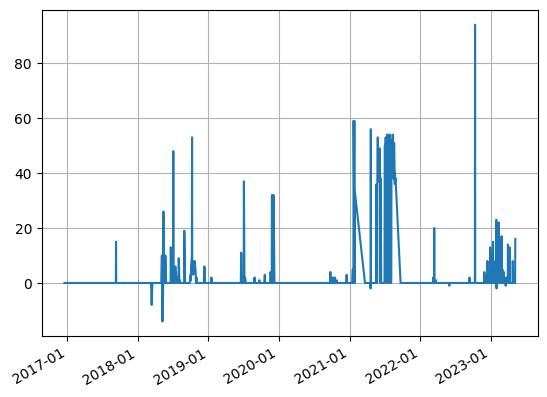

In [35]:
plot_data(train_single["Date"], train_single["Delay"])

- Single train daily autocorr

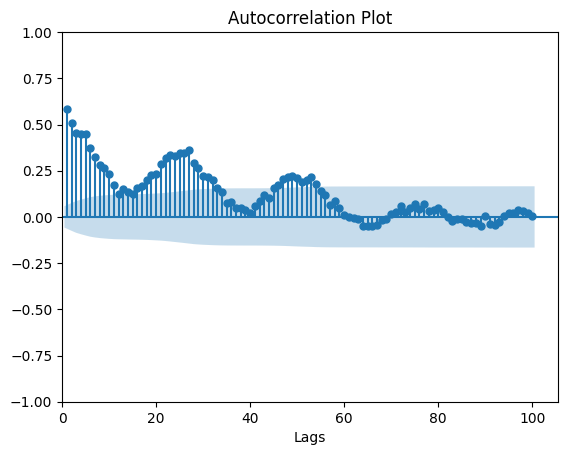

In [36]:
autocorr_data(train_single["Delay"], maxlag=100)

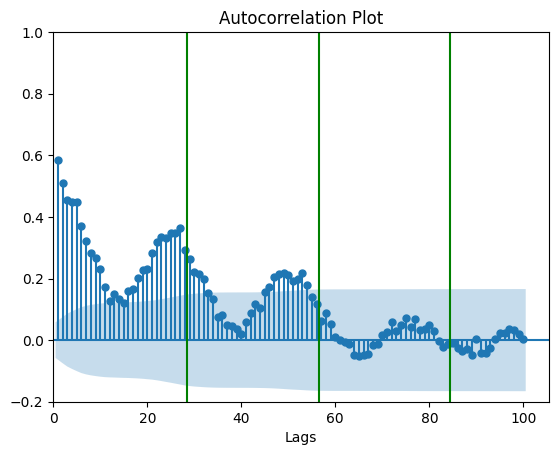

In [37]:
autocorr_data(train_single["Delay"], maxlag=100, ytop=1, ybottom=-0.2, step=28)

**PACF** is a time series analysis tool that helps understand how much the current value is related to its previous time points. In contrast to the standard autocorrelation, PACF focuses solely on the direct influences of previous time steps, simultaneously eliminating the impact of intermediate steps.

*For example*, the PACF value for lag 3 measures the correlation between the current time point and the value from three time steps ago, while excluding the influence of lags 1 and 2. This enables a more precise examination of the direct connections between specific time points within the time series.

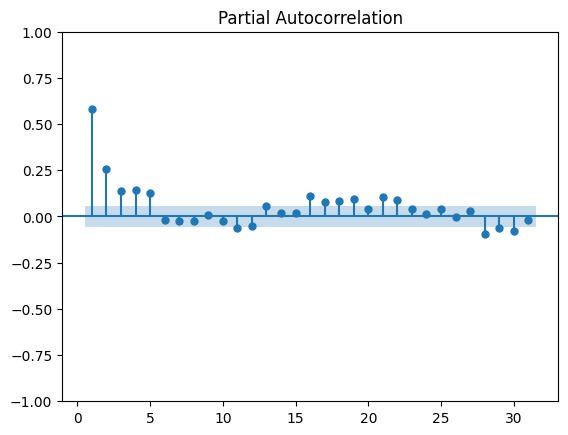

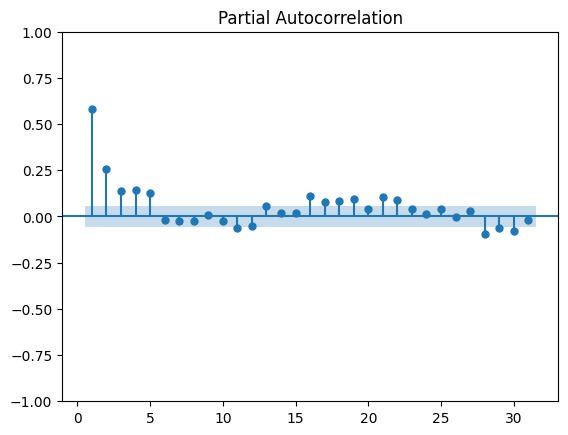

In [38]:
# Plot the PACF for train_single
plot_pacf(train_single["Delay"], zero=False)

- Plot single trains monthly delays

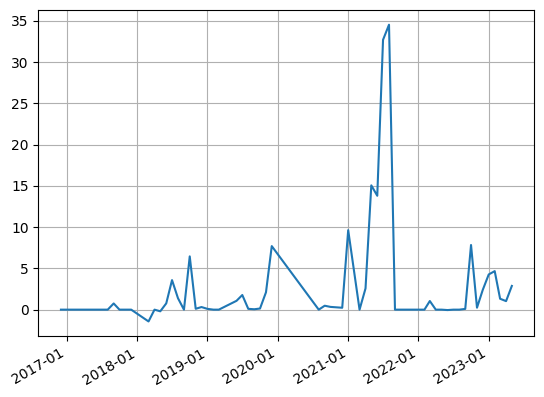

In [39]:
plot_data(train_single_monthly["Date"], train_single_monthly["Delay"])

- Single train monthly autocorr

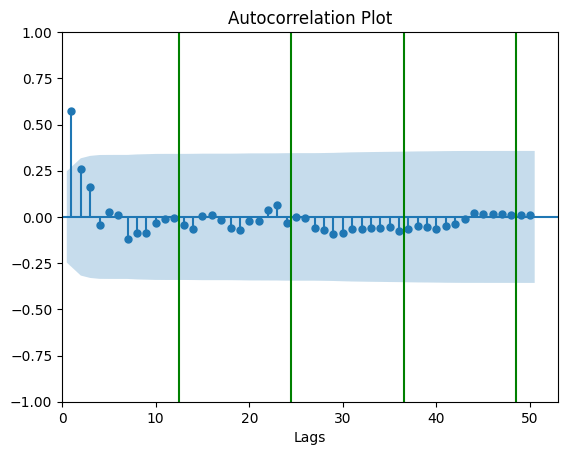

In [40]:
autocorr_data(train_single_monthly["Delay"], maxlag=50, step=12)

We can see a trend but not seasonality

## Analyze summed daily delay of all trains

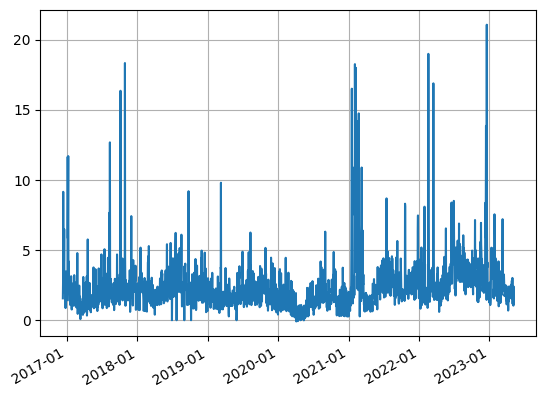

In [41]:
plot_data(df_grouped_daily["Date"], df_grouped_daily["Delay"])

- Autocorr

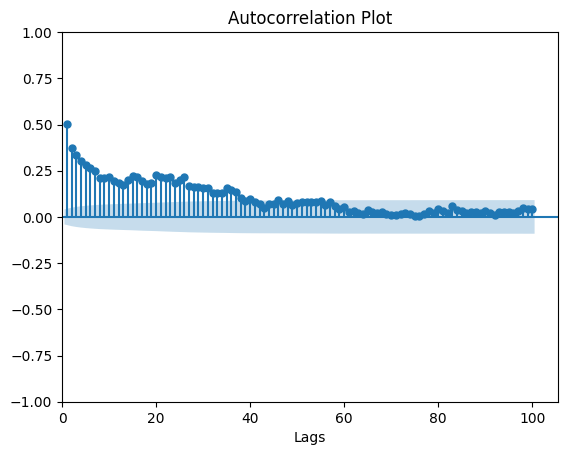

In [42]:
autocorr_data(df_grouped_daily["Delay"], maxlag=100)

We can see trend but not seasonality

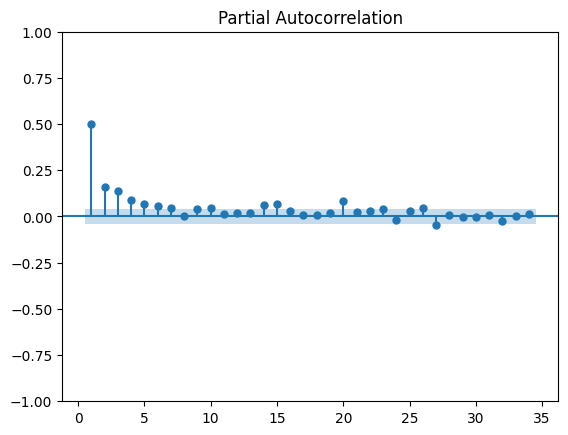

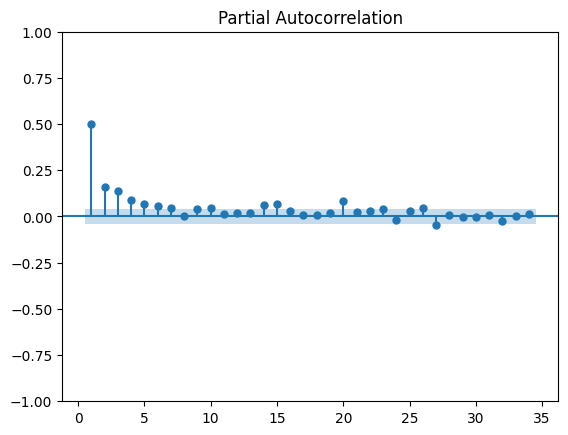

In [43]:
plot_pacf(df_grouped_daily["Delay"], zero=False)

## Analyze all trains summed monthly delays

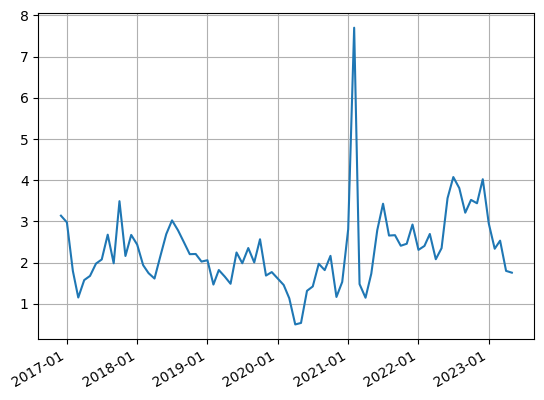

In [44]:
plot_data(df_grouped_monthly_all["Date"], df_grouped_monthly_all["Delay"])

Lets **change 2021 February Delays as it looks like an outlier**

### Correction of atypical delay in February 2021

In February 2021, unusually high delays were observed, significantly impacting the overall chart. To ensure a more accurate analysis, we can adjust this value by assigning it the second-highest delay among all months. This correction aims to mitigate the influence of a singular, atypical event on the overall depiction of delays.

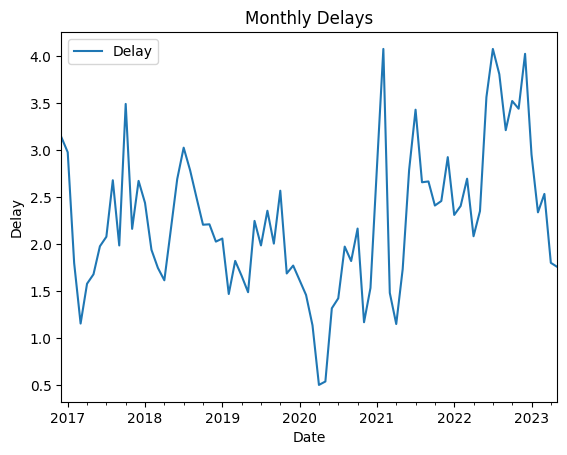

In [45]:
top3_largest_delays = df_grouped_monthly_all.sort_values("Delay", ascending=False).head(
    3
)

df_grouped_monthly_all.loc[df_grouped_monthly_all["Date"] == "2021-02-01", "Delay"] = (
    top3_largest_delays.values[1][1]
)

df_grouped_monthly_all.plot(x="Date", y="Delay", kind="line")
plt.xlabel("Date")
plt.ylabel("Delay")
plt.title("Monthly Delays")
plt.show()

- Autocorr

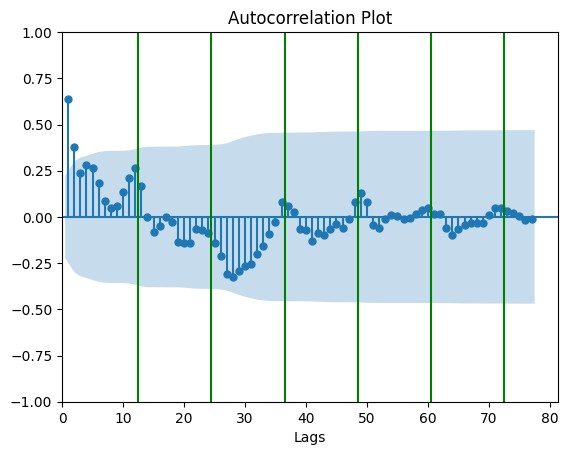

In [46]:
autocorr_data(df_grouped_monthly_all["Delay"], maxlag=77, step=12)

We can see trend and seasonality of 12 (months)

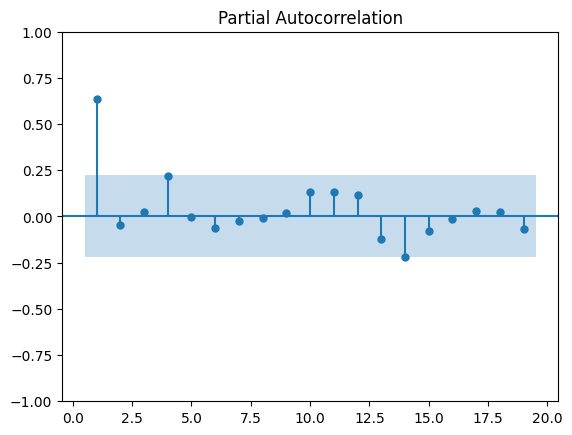

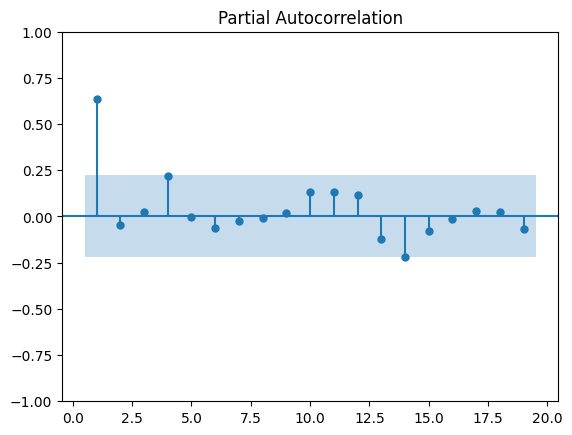

In [47]:
plot_pacf(df_grouped_monthly_all["Delay"], zero=False)

We can see a trend of 1 month

### Quick Dickey-Fullter test to make sure our data is seasonal
### Dickey-Fuller Test for Seasonality:

**The Dickey-Fuller test** is employed in time series analysis to check whether the data shows evidence of seasonality, indicating cyclical and repetitive patterns over time.

This test is based on comparing the p-value with a specified significance level, commonly 0.05. If the p-value is lower than this level, we reject the null hypothesis, which in this case would mean that the data is seasonal.

In [48]:
# Perform the Dickey-Fuller test
result = adfuller(df_grouped_monthly_all["Delay"], autolag="AIC")

# Extract the p-value from the test result
p_value = result[1]
# Check if the data is seasonal based on the p-value
if p_value < 0.05:
    print("The data is most likely seasonal.")
else:
    print("The data is most likely not seasonal.")

The data is most likely seasonal.


# SARIMAX MODEL

The SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) model is a time series forecasting model that extends the ARIMA model by incorporating seasonal components and exogenous variables.

### Components of SARIMAX Model

1. AR (AutoRegressive) Component: This component captures the linear relationship between the current observation and a lagged set of observations.

2. MA (Moving Average) Component: This component captures the linear relationship between the current observation and the residual errors from a moving average model applied to lagged observations.

3. I (Integrated) Component: This component captures the differencing of the time series to make it stationary.

4. S (Seasonal) Component: This component captures the seasonal patterns in the time series data.

5. X (Exogenous) Component: This component captures the impact of external factors on the time series.


## Model

In [49]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from pmdarima import auto_arima

# Fit the SARIMAX model with optimized parameters
model = auto_arima(df_grouped_monthly_all["Delay"], seasonal=True, m=12)
# Print the model summary
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   78
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 -66.914
Date:                              Sat, 04 Jan 2025   AIC                            141.828
Time:                                      17:26:59   BIC                            151.255
Sample:                                           0   HQIC                           145.602
                                               - 78                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8972      0.236      3.797      0.000       0.434       1.360
ar.L1          0.60

auto_arima has chosen **SARIMAX(1, 0, 0)x(0, 0, [1], 12)** as the best model.

- AR(1): The positive coefficient (0.6080) indicates a strong correlation with the previous time step.
- Seasonal MA(12): The seasonal moving average coefficient (0.3272) is significant, capturing yearly seasonality.
- Intercept: The constant term is significant (0.8972).

Tests (Ljung-Box, Jarque-Bera, Heteroskedasticity) show no major issues with autocorrelation, normality, or variance, suggesting the model fits the data well.

Now that we have our general SARIMAX model, we need to find the best parameters (coeffiecients) for it

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

test_size = 24  # last 2 years
model = SARIMAX(
    df_grouped_monthly_all["Delay"].astype(float)[:-test_size],
    order=(1, 0, 0),
    seasonal_order=(1, 0, 0, 12),
)

# Fit the model to the data
model_fit = model.fit(disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Delay   No. Observations:                   54
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 -54.121
Date:                            Sat, 04 Jan 2025   AIC                            114.242
Time:                                    17:26:59   BIC                            120.209
Sample:                                         0   HQIC                           116.544
                                             - 54                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8934      0.043     20.694      0.000       0.809       0.978
ar.S.L12       0.4739      0.178      2.664      0.008       0.125       0.822
sigma2         0.3968      0.066      6.018      0.000       0.268       0.526
===================================================================================
Ljung-Box (L1) (Q):                   4.41   Jarque-Bera (JB):                10.53
Prob(Q):                              0.04   Prob(JB):                         0.01
Heteroskedasticity (H):               1.62   Skew:                            -0.50
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can see the suggested coefficients:
- AR(1) (ar.L1) ~ 0.9
- Seasonal AR(12) (ar.S.L12) ~ 0.48
- sigma² (the error variance) ~ 0.4

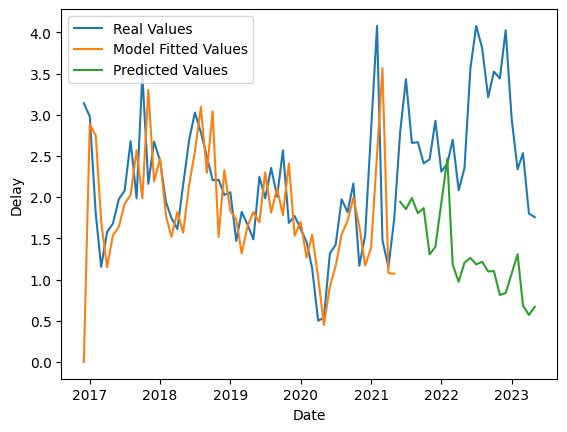

In [51]:
# Convert train_data['Date'] to float
date_float = df_grouped_monthly_all["Date"]

# Plot real values
plt.plot(date_float, df_grouped_monthly_all["Delay"], label="Real Values")

# Plot model fitted values
fitted_values = model_fit.fittedvalues
plt.plot(date_float[:-test_size], fitted_values, label="Model Fitted Values")

# Plot predicted values
predicted_values = model_fit.predict(
    start=len(df_grouped_monthly_all["Delay"]) - test_size, end=len(df_grouped_monthly_all["Delay"]) - 1
)
plt.plot(date_float[-test_size:], predicted_values, label="Predicted Values")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Delay")
plt.legend()

# Show the plot
plt.show()

In [52]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(df_grouped_monthly_all["Delay"][-test_size:], predicted_values)
print("RMSE:", rmse)

RMSE: 1.7308742406208366


We can see that the predicted model resembles the seasonality well.

Even tought the difference between real and predicted is significant.